In [1]:
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import lsst.daf.persistence as dafPersist
import lsst.daf.base        as dafBase
import lsst.afw.table as afwTable
from lsst.meas.algorithms.detection    import SourceDetectionTask
from lsst.meas.base import NoiseReplacer, NoiseReplacerConfig
import lsst.afw.detection as afwDetection
import lsst.afw.display as afwDisplay
from skimage.filters import threshold_otsu

from lsst.geom import Extent2D, Point2D, SpherePoint
from lsst.geom import degrees as geomDeg
%matplotlib inline

## Load data

### Load image

In [2]:
repo_dir = '/astro/users/brycek/epyc/users/brycek/Commissioning/aos/ts_phosim/notebooks/analysis_scripts/test_output/blendTest_5/input/rerun/run1'
butler = dafPersist.Butler(repo_dir)

In [3]:
raft = 'R22'
detector = 'S11'
data_id = {'visit': 9006001, 'filter': 'g', 'raftName': raft, 'detectorName': detector}

In [73]:
raw = butler.get('postISRCCD', **data_id)

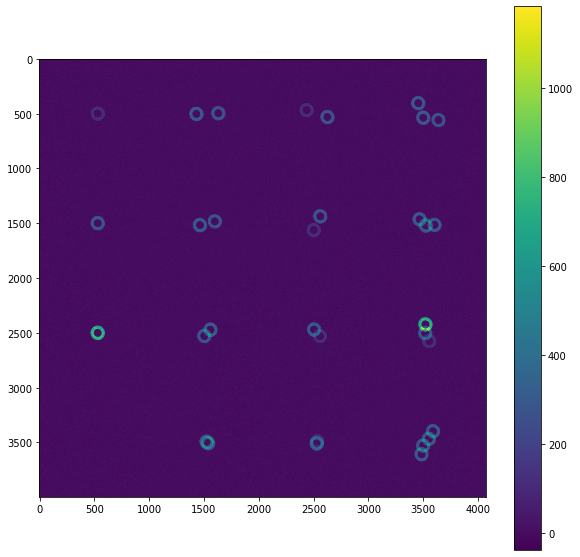

In [8]:
# Plot image array
fig = plt.figure(figsize=(10, 10))
plt.imshow(raw.image.array)
plt.colorbar()

In [76]:
from skimage.filters import threshold_local, try_all_threshold, threshold_triangle

skimage.filters.thresholding.threshold_isodata
skimage.filters.thresholding.threshold_li
skimage.filters.thresholding.threshold_mean
skimage.filters.thresholding.threshold_minimum
skimage.filters.thresholding.threshold_otsu
skimage.filters.thresholding.threshold_triangle
skimage.filters.thresholding.threshold_yen


(<Figure size 1008x1440 with 8 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f3bf7fabe10>,
       dtype=object))

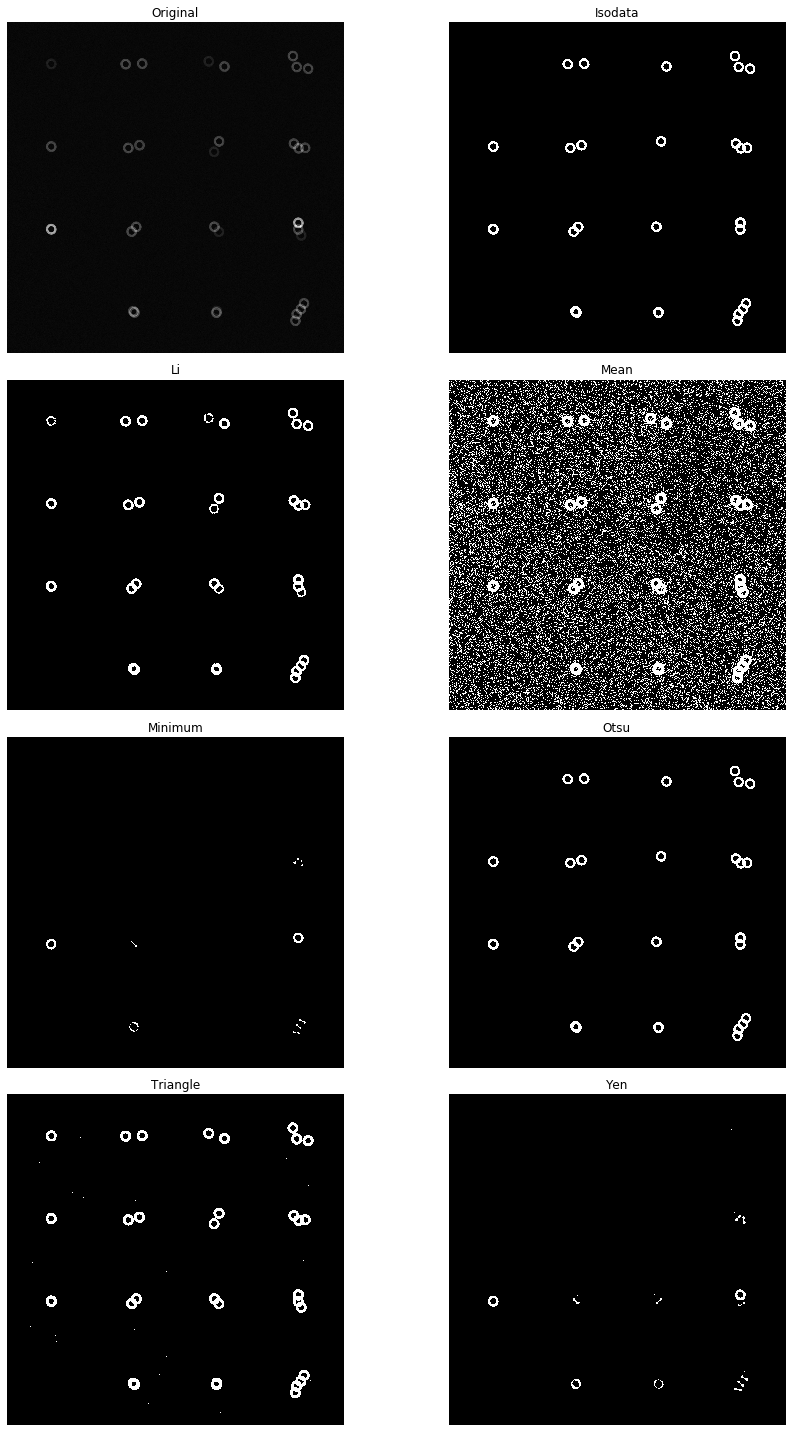

In [75]:
try_all_threshold(raw.image.array, figsize=(14, 20))

In [6]:
image_thresh = threshold_otsu(raw.image.array)
raw.image.array[raw.image.array <= image_thresh] = 0.
raw.image.array[raw.image.array > image_thresh] = 1.

In [78]:
image_thresh = threshold_triangle(raw.image.array)
raw.image.array[raw.image.array <= image_thresh] = 0.
raw.image.array[raw.image.array > image_thresh] = 1.

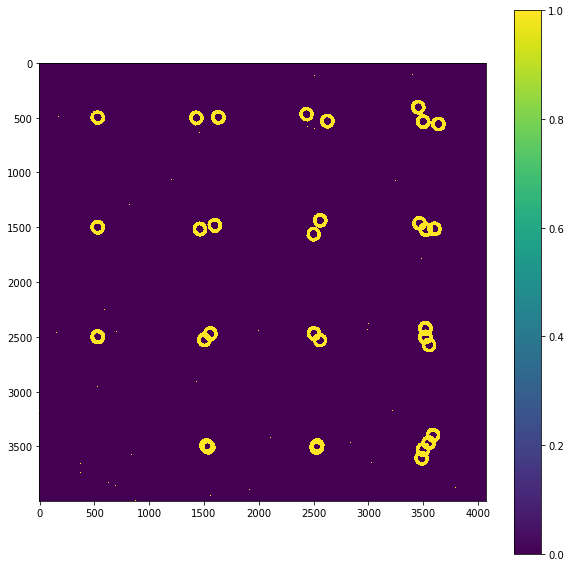

In [79]:
# Plot image array
fig = plt.figure(figsize=(10, 10))
plt.imshow(raw.image.array)
plt.colorbar()

### Load template

In [26]:
template_filename = os.path.join(os.environ['TS_WEP_DIR'], 'policy', 'deblend', 'data', 'extra_template-%s_%s.txt' % (raft, detector))

In [27]:
template_image = np.genfromtxt(template_filename)

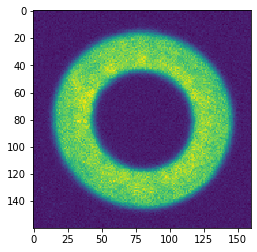

In [28]:
plt.imshow(template_image)

In [29]:
template_thresh = threshold_otsu(template_image)
binary_template = np.array(template_image)
binary_template[binary_template <= template_thresh] = 0.
binary_template[binary_template > template_thresh] = 1.

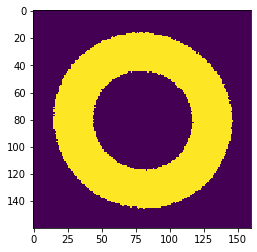

In [30]:
plt.imshow(binary_template)

## Run Centroid Finder

In [31]:
from lsst.ts.wep.deblend.BlendedImageDecorator import BlendedImageDecorator
from lsst.ts.wep.cwfs.CompensableImage import CompensableImage

In [32]:
#convolution/correlation code for centroids
from lsst.afw.image import Image, Mask, MaskedImage, ImageF, MaskedImageF, ExposureF
from numpy.fft import fft2, ifft2
from scipy.signal import fftconvolve, correlate2d

def convolveExposureWithImage(exposure, kernelImage):
    '''Convolve image and variance planes in an exposure with an image using FFT
        Does not convolve mask. Returns new exposure'''
    
    newExposure = exposure.clone() 

    image = convolveImageWithImage(newExposure.getImage(), kernelImage)
    variance = convolveImageWithImage(newExposure.getVariance(), kernelImage)
    
    newExposure.image = image
    newExposure.variance = variance
    return newExposure

def convolveImageWithImage(image, kernelImage, conv=True, fft=True):
    '''Convolve/correlate an image with a kernel
        Option to use an FFT or direct (slow)
        Returns an image'''
    if conv:
        array = fftconvolve(image.getArray(), kernelImage.getArray(), mode='same')
    else:
        if fft:
            array = np.roll(ifft2(fft2(kernelImage.getArray()).conj()*fft2(image.getArray())).real, 
                         (image.getArray().shape[0] - 1)//2, axis=(0,1))
        else:
            array = correlate2d(image.getArray(), kernelImage.getArray(), mode='same')
    newImage = ImageF(array.shape[1], array.shape[0])
    newImage.array[:] = array
    return newImage

In [80]:
binary_template_image = ImageF(np.shape(template_image)[0], np.shape(template_image)[1])
binary_template_image.array[:] = binary_template
new_exp = convolveExposureWithImage(raw, binary_template_image)

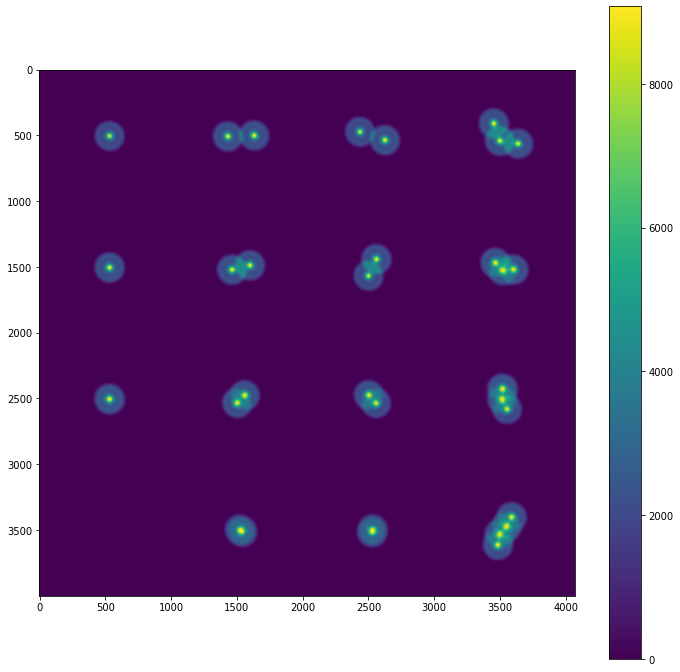

In [81]:
fig = plt.figure(figsize=(12,12))
plt.imshow(new_exp.image.array)
plt.colorbar()

## Rank results

### Test on input catalog

In [82]:
input_cat = np.genfromtxt('/astro/users/brycek/epyc/users/brycek/Commissioning/aos/ts_phosim/notebooks/analysis_scripts/starCatBlendTest.txt', unpack=True)

In [83]:
input_cat

array([[ 0.0000e+00,  1.0000e+00,  2.0000e+00,  3.0000e+00,  4.0000e+00,
         5.0000e+00,  6.0000e+00,  7.0000e+00,  8.0000e+00,  9.0000e+00,
         1.0000e+01,  1.1000e+01,  1.2000e+01,  1.3000e+01,  1.4000e+01,
         1.5000e+01,  1.6000e+01,  1.7000e+01,  1.8000e+01,  1.9000e+01,
         2.0000e+01,  2.1000e+01,  2.2000e+01,  2.3000e+01,  2.4000e+01,
         2.5000e+01,  2.6000e+01,  2.7000e+01,  2.8000e+01,  2.9000e+01,
         3.0000e+01,  3.1000e+01],
       [-8.3333e-02, -2.7778e-02,  2.7778e-02, -8.3519e-02, -8.3148e-02,
        -2.8721e-02, -2.6835e-02,  2.6196e-02,  2.9359e-02,  8.2950e-02,
         8.3717e-02, -8.5081e-02, -8.1585e-02, -3.1289e-02, -2.4267e-02,
         2.6120e-02,  2.9436e-02,  8.2794e-02,  8.3872e-02, -8.8628e-02,
        -8.1273e-02, -8.0099e-02, -2.9745e-02, -2.6635e-02, -2.6953e-02,
         2.3487e-02,  2.7930e-02,  3.1916e-02,  7.7624e-02,  8.1510e-02,
         8.4914e-02,  8.9285e-02],
       [-8.3333e-02, -8.3333e-02, -8.3333e-02, -2.2225

In [84]:
from sklearn.neighbors import NearestNeighbors

In [85]:
X = input_cat[1:3].T*3600/.2

In [86]:
nbrs = NearestNeighbors(n_neighbors=4).fit(X)

In [87]:
distances, indices = nbrs.kneighbors(X)

In [88]:
unblended = np.where(distances[:,1] > 126.)
blended = np.where(distances[:,1] <= 126.)

In [89]:
unblended, blended

((array([ 0,  1,  2,  3,  4,  5,  6, 11, 12, 13, 14, 19, 20, 21]),),
 (array([ 7,  8,  9, 10, 15, 16, 17, 18, 22, 23, 24, 25, 26, 27, 28, 29, 30,
         31]),))

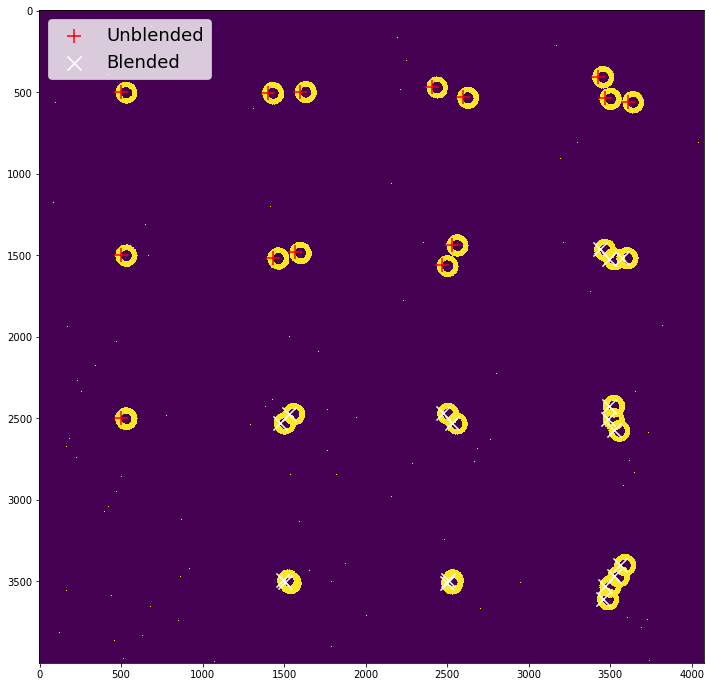

In [90]:
fig = plt.figure(figsize=(12,12))
plt.imshow(raw.image.array)
plt.scatter(X[unblended,1]+2000., X[unblended,0]+2000., c='r', s=200, marker='+', label='Unblended')
plt.scatter(X[blended,1]+2000., X[blended,0]+2000., c='white', s=200, marker='x', label='Blended')
plt.legend(fontsize=18)

Text(0.5, 1.0, 'Blendedness derived from catalog input')

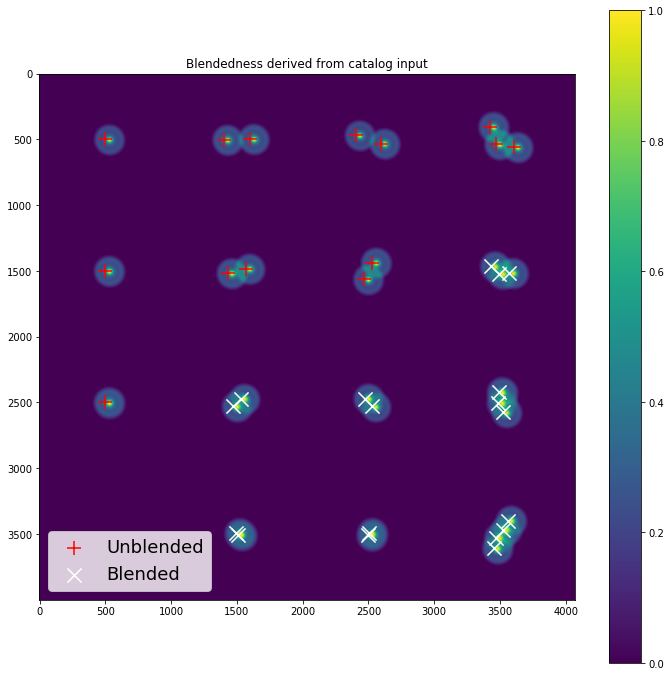

In [163]:
fig = plt.figure(figsize=(12,12))
plt.imshow(new_exp.image.array)
plt.scatter(X[unblended,1]+2000., X[unblended,0]+2000., c='r', s=200, marker='+', label='Unblended')
plt.scatter(X[blended,1]+2000., X[blended,0]+2000., c='white', s=200, marker='x', label='Blended')
plt.legend(fontsize=18)
plt.colorbar()
plt.title('Blendedness derived from catalog input')

### Detect blended objects using images

Here we convolve the image with our template donut and use the `DBSCAN` clustering method
to find the peaks in the convolved image. Then we measure the distance between these peaks
to identify objects that overlap and are blended.

In [93]:
ranked_convolve = np.argsort(new_exp.image.array.flatten())[::-1]
cutoff = len(np.where(new_exp.image.array.flatten() > 0.9*np.max(new_exp.image.array))[0])
ranked_convolve = ranked_convolve[:cutoff]
nx, ny = np.unravel_index(ranked_convolve, np.shape(new_exp.image.array))

In [100]:
from sklearn.cluster import DBSCAN

In [118]:
dbs = DBSCAN(eps=2.).fit(np.array([ny, nx]).T)

In [119]:
np.array([ny, nx]).T

array([[1529, 3499],
       [3468, 1469],
       [2563, 1445],
       ...,
       [ 543, 1501],
       [3511, 3531],
       [1439,  503]])

In [120]:
dbs.labels_

array([ 0,  1,  2, ..., 17, 21, 24])

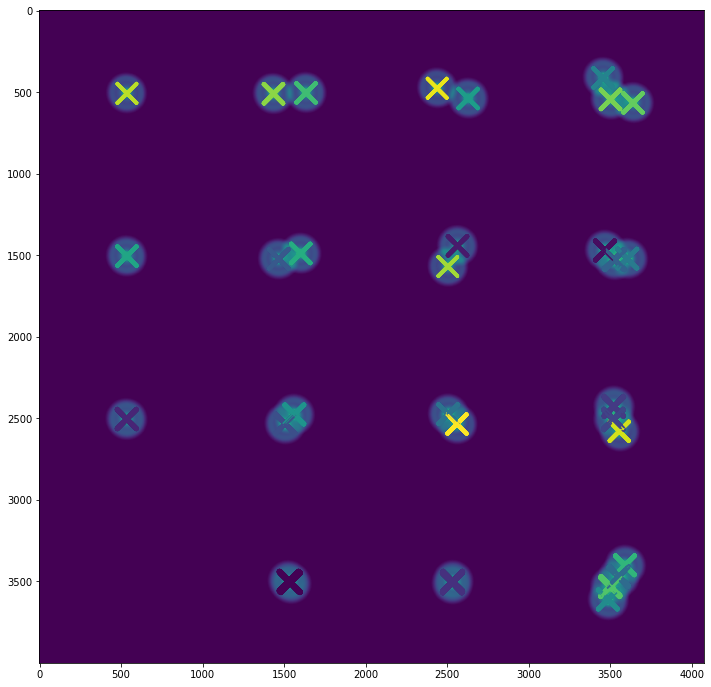

In [121]:
fig = plt.figure(figsize=(12,12))
plt.imshow(new_exp.image.array)
plt.scatter(ny, nx, c=dbs.labels_, marker='x', s=400)

In [122]:
np.unique(dbs.labels_)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29])

In [112]:
len(X)

32

In [127]:
dbs_cluster_centers = []
for i in np.unique(dbs.labels_):
    ny_cluster = ny[np.where(dbs.labels_ == i)]
    nx_cluster = nx[np.where(dbs.labels_ == i)]
    dbs_cluster_centers.append([np.mean(ny_cluster), np.mean(nx_cluster)])
dbs_cluster_centers = np.array(dbs_cluster_centers)

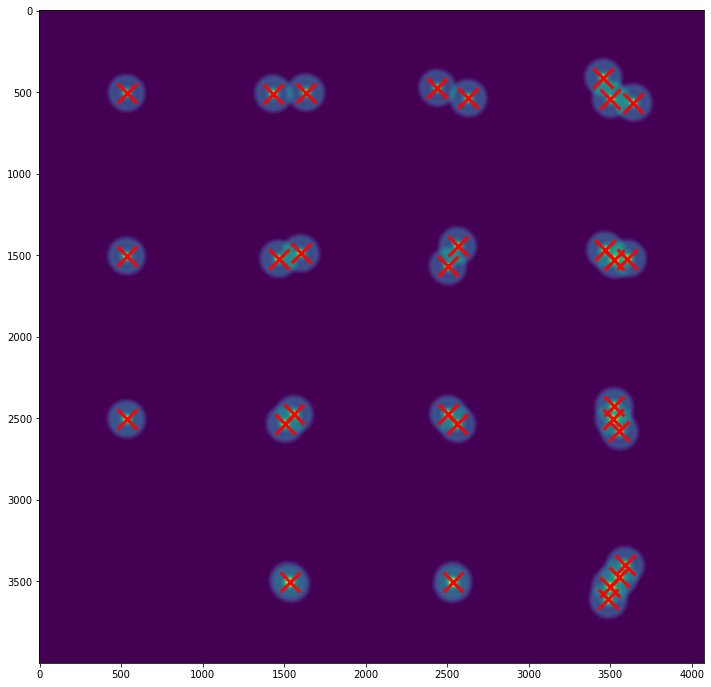

In [130]:
fig = plt.figure(figsize=(12,12))
plt.imshow(new_exp.image.array)
plt.scatter(dbs_cluster_centers[:,0], dbs_cluster_centers[:,1], c='r', marker='x', s=400, lw=3)

In [131]:
from scipy.spatial.distance import cdist

In [133]:
dist_matrix = cdist(dbs_cluster_centers, dbs_cluster_centers)

In [134]:
np.where(((dist_matrix > 0.) & (dist_matrix < 126.)))

(array([ 1,  5,  6,  6,  7,  9,  9, 10, 10, 11, 12, 14, 15, 19, 21, 21, 27,
        29]),
 array([ 9,  6,  5, 27, 15,  1, 12, 19, 21, 29,  9, 21,  7, 10, 10, 14,  6,
        11]))

In [136]:
dist_matrix_upper = np.triu(dist_matrix)

In [144]:
blended_pairs = np.array(np.where((dist_matrix_upper > 0.) & (dist_matrix_upper < 126.))).T

In [146]:
blended_cluster_centers = np.unique(blended_pairs.flatten())

In [157]:
unblended_cluster_centers = [j for j in range(len(dbs_cluster_centers)) if j not in blended_cluster_centers]

In [147]:
blended_cluster_centers

array([ 1,  5,  6,  7,  9, 10, 11, 12, 14, 15, 19, 21, 27, 29])

In [158]:
unblended_cluster_centers

[0, 2, 3, 4, 8, 13, 16, 17, 18, 20, 22, 23, 24, 25, 26, 28]

Text(0.5, 1.0, 'Detected using convolution and DBSCAN')

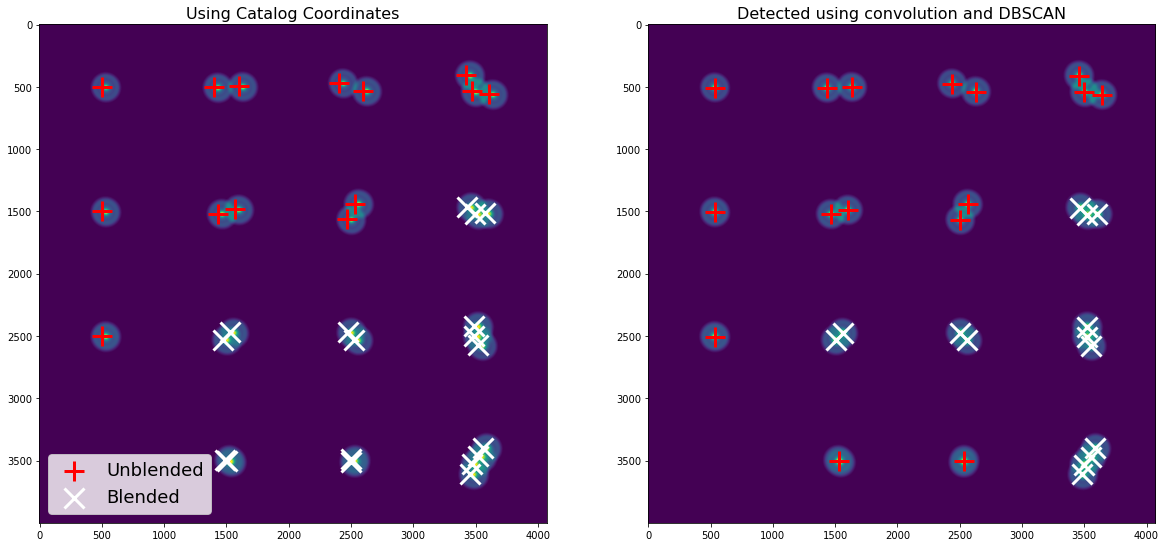

In [162]:
fig = plt.figure(figsize=(20,14))
fig.add_subplot(1,2,1)
plt.imshow(new_exp.image.array)
plt.scatter(X[unblended,1]+2000., X[unblended,0]+2000., c='r', s=400, marker='+', lw=3, label='Unblended')
plt.scatter(X[blended,1]+2000., X[blended,0]+2000., c='white', s=400, marker='x', lw=3, label='Blended')
plt.legend(fontsize=18)
#plt.colorbar()
plt.title('Using Catalog Coordinates', size=16)
fig.add_subplot(1,2,2)
plt.imshow(new_exp.image.array)
plt.scatter(dbs_cluster_centers[unblended_cluster_centers,0], 
            dbs_cluster_centers[unblended_cluster_centers,1], c='r', marker='+', s=400, lw=3)
plt.scatter(dbs_cluster_centers[blended_cluster_centers,0], 
            dbs_cluster_centers[blended_cluster_centers,1], c='w', marker='x', s=400, lw=3)
plt.title('Detected using convolution and DBSCAN', size=16)